<a href="https://colab.research.google.com/github/onurkasap/Computer-Vision/blob/main/yolo_v8_traffic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q ultralytics opencv-python matplotlib pandas

Colab üzerinden eğitim sağlanacağı için Nvidia donanımı olarak T4-GPU seçildi. Duruma göre farklı GPU'lar da seçilebilir.

In [ ]:
!nvidia-smi

Wed Aug 20 12:51:17 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   47C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
from ultralytics import YOLO
import os, textwrap, json, shutil, random, glob, pathlib, collections

Projeyi Google Drive'a bağlamak için

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
PROJ = "/content/drive/MyDrive/traffic-sign-yolo"
os.makedirs(f"{PROJ}", exist_ok=True)
print("PROJ:", PROJ)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
PROJ: /content/drive/MyDrive/traffic-sign-yolo


In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="xxxxxxxxxxxxxxxx") # buraya kendi yolo api key'inizi yazacaksınız
project = rf.workspace("roboflow-100").project("road-signs-6ih4y")
version = project.version(2)
dataset = version.download("coco")

loading Roboflow workspace...
loading Roboflow project...


In [ ]:
DATASET_DIR = pathlib.Path(dataset.location)
print("Daaset:", DATASET_DIR)
print("Alt Dizinler: ", list(DATASET_DIR.glob("*")))

Daaset: /content/road-signs-2
Alt Dizinler:  [PosixPath('/content/road-signs-2/valid'), PosixPath('/content/road-signs-2/train'), PosixPath('/content/road-signs-2/README.dataset.txt'), PosixPath('/content/road-signs-2/test'), PosixPath('/content/road-signs-2/README.roboflow.txt')]


COCO formatındaki annotation dosyasını (_annotations.coco.json) alıp, onu YOLO formatındaki .txt dosyalarına dönüştürmek için yazılan fonksiyon

In [ ]:
import os, json, glob, shutil, pathlib, collections, textwrap

def coco_to_yolo_split(ann_path, labels_dir, category_id_to_idx, img_sizes):
    os.makedirs(labels_dir, exist_ok=True)
    with open(ann_path, "r") as f:
        coco = json.load(f)

    grouped = collections.defaultdict(list)
    for ann in coco["annotations"]:
        grouped[ann["image_id"]].append(ann)

    # her image için .txt yaz
    for img in coco["images"]:
        img_id = img["id"]
        w, h = img["width"], img["height"]
        img_sizes[img_id] = (w, h)
        stem = pathlib.Path(img["file_name"]).stem
        out_txt = pathlib.Path(labels_dir)/f"{stem}.txt"

        lines = []
        for ann in grouped.get(img_id, []):
            cat_id = ann["category_id"]
            if cat_id not in category_id_to_idx:
                continue
            cls = category_id_to_idx[cat_id]
            x, y, bw, bh = ann["bbox"]  # COCO: x_min, y_min, w, h
            xc = (x + bw/2) / w
            yc = (y + bh/2) / h
            ww = bw / w
            hh = bh / h
            # clip
            xc = min(max(xc, 0.0), 1.0)
            yc = min(max(yc, 0.0), 1.0)
            ww = min(max(ww, 0.0), 1.0)
            hh = min(max(hh, 0.0), 1.0)
            lines.append(f"{cls} {xc:.6f} {yc:.6f} {ww:.6f} {hh:.6f}")

        with open(out_txt, "w") as f:
            f.write("\n".join(lines))

Bütün COCO datasetini (train, valid, test klasörleri) alıp,
tamamen YOLOv8’in beklediği klasör yapısına dönüştürmek için yazılan fonksiyon

In [ ]:
def convert_coco_dataset(dataset_dir, dest_root):
    """
    Kaynak klasörleri (train/valid/test) olduğu gibi kullan;
    sadece hedefte valid -> val olarak adlandır.
    """
    dataset_dir = pathlib.Path(dataset_dir)
    dest_root = pathlib.Path(dest_root)

    # kaynak -> hedef split eşlemesi
    split_map = []
    for src in ["train", "valid", "val", "test"]:
        p = dataset_dir/src
        if p.exists():
            dst = "val" if src in ("valid", "val") else src
            split_map.append((src, dst))

    # categories ve names
    ann_any = None
    for src, _ in split_map:
        cand = dataset_dir/src/"_annotations.coco.json"
        if cand.exists():
            ann_any = cand
            break
    assert ann_any is not None, "COCO annotation dosyası bulunamadı."

    with open(ann_any, "r") as f:
        coco_any = json.load(f)
    categories = sorted(coco_any["categories"], key=lambda c: c["id"])
    names = [c["name"] for c in categories]
    cat_id_to_idx = {c["id"]: i for i, c in enumerate(categories)}

    # hedef klasörleri hazırla
    for dst in ["train", "val", "test"]:
        (dest_root/"images"/dst).mkdir(parents=True, exist_ok=True)
        (dest_root/"labels"/dst).mkdir(parents=True, exist_ok=True)

    # kopyala + etiket yaz
    img_sizes = {}
    for src, dst in split_map:
        src_dir = dataset_dir/src
        ann_json = src_dir/"_annotations.coco.json"
        if not ann_json.exists():
            # split'inde annotation yoksa atla
            continue

        # Görüntüler
        for ext in ("*.jpg","*.jpeg","*.png","*.bmp","*.webp"):
            for imgp in src_dir.glob(ext):
                shutil.copy(imgp, dest_root/"images"/dst/imgp.name)

        # Label yaz
        coco_to_yolo_split(ann_json, dest_root/"labels"/dst, cat_id_to_idx, img_sizes)

    return names


Döüşüm

In [ ]:
DEST = f"{PROJ}/data"  # YOLOv8 hedef kök
shutil.rmtree(DEST, ignore_errors=True)  # temiz başla (isteğe bağlı)
names = convert_coco_dataset(DATASET_DIR, DEST)
print("Sınıflar:", names)
print("Dönüşüm tamamlandı ->", DEST)


Sınıflar: ['road-signs', 'bus_stop', 'do_not_enter', 'do_not_stop', 'do_not_turn_l', 'do_not_turn_r', 'do_not_u_turn', 'enter_left_lane', 'green_light', 'left_right_lane', 'no_parking', 'parking', 'ped_crossing', 'ped_zebra_cross', 'railway_crossing', 'red_light', 'stop', 't_intersection_l', 'traffic_light', 'u_turn', 'warning', 'yellow_light']
Dönüşüm tamamlandı -> /content/drive/MyDrive/traffic-sign-yolo/data


In [ ]:
data_yaml = f"""
path: {PROJ}/data
train: images/train
val: images/val
test: images/test
names:
""" + "\n".join([f"  {i}: {n}" for i, n in enumerate(names)])

with open(f"{PROJ}/data.yaml", "w") as f:
    f.write(textwrap.dedent(data_yaml).strip()+"\n")

print(open(f"{PROJ}/data.yaml").read())


path: /content/drive/MyDrive/traffic-sign-yolo/data
train: images/train
val: images/val
test: images/test
names:
  0: road-signs
  1: bus_stop
  2: do_not_enter
  3: do_not_stop
  4: do_not_turn_l
  5: do_not_turn_r
  6: do_not_u_turn
  7: enter_left_lane
  8: green_light
  9: left_right_lane
  10: no_parking
  11: parking
  12: ped_crossing
  13: ped_zebra_cross
  14: railway_crossing
  15: red_light
  16: stop
  17: t_intersection_l
  18: traffic_light
  19: u_turn
  20: warning
  21: yellow_light



In [ ]:
data_yaml = f"""
path: {PROJ}/data
train: images/train
val: images/val
test: images/test
names:
""" + "\n".join([f"  {i}: {n}" for i, n in enumerate(names)])

with open(f"{PROJ}/data.yaml", "w") as f:
    f.write(textwrap.dedent(data_yaml).strip()+"\n")

print(open(f"{PROJ}/data.yaml").read())


path: /content/drive/MyDrive/traffic-sign-yolo/data
train: images/train
val: images/val
test: images/test
names:
  0: road-signs
  1: bus_stop
  2: do_not_enter
  3: do_not_stop
  4: do_not_turn_l
  5: do_not_turn_r
  6: do_not_u_turn
  7: enter_left_lane
  8: green_light
  9: left_right_lane
  10: no_parking
  11: parking
  12: ped_crossing
  13: ped_zebra_cross
  14: railway_crossing
  15: red_light
  16: stop
  17: t_intersection_l
  18: traffic_light
  19: u_turn
  20: warning
  21: yellow_light



Epoch süreci

In [ ]:
from ultralytics import YOLO
DATA = f"{PROJ}/data.yaml"
model = YOLO("yolov8n.pt")
model.train(data=DATA, imgsz=640, epochs=50, batch=16, optimizer="adamw", cos_lr=True, patience=15, device=0)

# best.pt'yi Drive'a kopyalar
import glob, os
last_run = sorted(glob.glob("/content/runs/detect/*"), key=os.path.getmtime)[-1]
BEST = f"{last_run}/weights/best.pt"
dst = f"{PROJ}/artifacts/best.pt"
os.makedirs(os.path.dirname(dst), exist_ok=True)
shutil.copy(BEST, dst)
print("BEST ->", dst)


Ultralytics 8.3.182 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/content/drive/MyDrive/traffic-sign-yolo/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=adamw, overlap_mask=True, patience=15, perspective=0.0, plots=True, pos

Overriding model.yaml nc=80 with nc=22

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytic

 17            [-1, 12]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 18                  -1  1    123648  ultralytics.nn.modules.block.C2f             [192, 128, 1]                 
 19                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
 20             [-1, 9]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 21                  -1  1    493056  ultralytics.nn.modules.block.C2f             [384, 256, 1]                 
 22        [15, 18, 21]  1    755602  ultralytics.nn.modules.head.Detect           [22, [64, 128, 256]]          
Model summary: 129 layers, 3,015,138 parameters, 3,015,122 gradients, 8.2 GFLOPs

Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


AMP: checks passed ✅
train: Fast image access ✅ (ping: 1.0±0.6 ms, read: 18.3±16.6 MB/s, size: 39.1 KB)


train: Scanning /content/drive/MyDrive/traffic-sign-yolo/data/labels/train... 1376 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1376/1376 [00:15<00:00, 86.18it/s] 


train: New cache created: /content/drive/MyDrive/traffic-sign-yolo/data/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.4±0.0 ms, read: 16.5±7.7 MB/s, size: 44.6 KB)


val: Scanning /content/drive/MyDrive/traffic-sign-yolo/data/labels/val... 488 images, 0 backgrounds, 0 corrupt: 100%|██████████| 488/488 [00:05<00:00, 92.17it/s] 


val: New cache created: /content/drive/MyDrive/traffic-sign-yolo/data/labels/val.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.13G      1.393      3.375      1.452         31        640: 100%|██████████| 86/86 [00:31<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.75it/s]

                   all        488        529      0.178      0.168   0.000917   0.000214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.62G      1.448      2.659      1.425         31        640: 100%|██████████| 86/86 [00:28<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.87it/s]


                   all        488        529     0.0574      0.289     0.0338     0.0204

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.63G      1.391      2.462      1.398         26        640: 100%|██████████| 86/86 [00:28<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.33it/s]


                   all        488        529      0.555     0.0531     0.0249     0.0105

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.65G      1.321      2.271      1.349         40        640: 100%|██████████| 86/86 [00:28<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.40it/s]


                   all        488        529      0.144      0.507      0.185      0.114

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.67G      1.253      2.081      1.315         34        640: 100%|██████████| 86/86 [00:28<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.75it/s]

                   all        488        529      0.238       0.67      0.305      0.219



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.68G      1.201      1.992      1.269         30        640: 100%|██████████| 86/86 [00:28<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.32it/s]


                   all        488        529      0.406      0.591      0.376      0.278

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50       2.7G      1.189      1.914      1.271         32        640: 100%|██████████| 86/86 [00:28<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.32it/s]


                   all        488        529      0.342      0.554      0.358      0.267

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.72G      1.145      1.825      1.228         31        640: 100%|██████████| 86/86 [00:27<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.77it/s]

                   all        488        529      0.328      0.702      0.489      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.73G      1.102      1.712      1.198         36        640: 100%|██████████| 86/86 [00:27<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.46it/s]

                   all        488        529      0.204      0.425      0.281      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.75G      1.134      1.716      1.216         38        640: 100%|██████████| 86/86 [00:27<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.46it/s]


                   all        488        529      0.287      0.564      0.347      0.238

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      2.77G      1.103      1.646      1.195         39        640: 100%|██████████| 86/86 [00:27<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.70it/s]

                   all        488        529      0.477       0.62      0.599      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.79G      1.053      1.579      1.188         28        640: 100%|██████████| 86/86 [00:27<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.33it/s]


                   all        488        529      0.517      0.479      0.505      0.374

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50       2.8G      1.055      1.494      1.176         31        640: 100%|██████████| 86/86 [00:27<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.43it/s]


                   all        488        529      0.378      0.665      0.564      0.418

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.82G       1.03       1.43      1.171         30        640: 100%|██████████| 86/86 [00:26<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.59it/s]


                   all        488        529      0.521      0.592      0.681      0.501

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.84G      1.046      1.376      1.171         31        640: 100%|██████████| 86/86 [00:27<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.49it/s]

                   all        488        529      0.546      0.683        0.7      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.85G      1.013       1.31      1.147         31        640: 100%|██████████| 86/86 [00:26<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.56it/s]


                   all        488        529      0.577      0.765      0.769      0.587

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.87G          1      1.271      1.136         25        640: 100%|██████████| 86/86 [00:27<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.60it/s]

                   all        488        529      0.637      0.688      0.747      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.89G     0.9993      1.237      1.137         28        640: 100%|██████████| 86/86 [00:27<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.46it/s]


                   all        488        529      0.643      0.696      0.702      0.529

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.91G     0.9668      1.148      1.126         39        640: 100%|██████████| 86/86 [00:27<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.62it/s]

                   all        488        529      0.764      0.758      0.817      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      2.92G      1.006      1.179      1.145         35        640: 100%|██████████| 86/86 [00:27<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.63it/s]

                   all        488        529      0.696       0.65      0.731      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      2.94G     0.9422      1.143      1.116         28        640: 100%|██████████| 86/86 [00:26<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.14it/s]

                   all        488        529      0.679      0.786      0.809      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.96G     0.9327      1.121      1.122         35        640: 100%|██████████| 86/86 [00:27<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.60it/s]

                   all        488        529      0.776      0.779      0.833      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      2.97G     0.9296      1.072      1.112         32        640: 100%|██████████| 86/86 [00:27<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.17it/s]

                   all        488        529      0.791      0.764      0.859      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.99G     0.9154      1.085      1.097         30        640: 100%|██████████| 86/86 [00:25<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.83it/s]


                   all        488        529      0.756      0.774      0.838      0.664

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      3.01G     0.8807      1.029       1.08         36        640: 100%|██████████| 86/86 [00:26<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.52it/s]


                   all        488        529      0.856       0.82      0.883      0.712

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      3.03G     0.9068      1.023      1.087         36        640: 100%|██████████| 86/86 [00:26<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.60it/s]

                   all        488        529       0.86      0.817      0.882      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      3.04G     0.8817     0.9755       1.08         41        640: 100%|██████████| 86/86 [00:26<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.83it/s]

                   all        488        529      0.815      0.861      0.901      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      3.06G     0.8648     0.9324      1.075         34        640: 100%|██████████| 86/86 [00:26<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.33it/s]

                   all        488        529      0.858       0.84      0.901      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      3.08G     0.8856     0.9272      1.089         35        640: 100%|██████████| 86/86 [00:26<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.49it/s]

                   all        488        529       0.84       0.84      0.878      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      3.09G     0.8779     0.9492      1.074         32        640: 100%|██████████| 86/86 [00:26<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.25it/s]

                   all        488        529      0.856      0.827      0.898       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      3.11G     0.8541     0.8789      1.071         29        640: 100%|██████████| 86/86 [00:25<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.57it/s]

                   all        488        529      0.856      0.837      0.903      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      3.13G     0.8054     0.8396      1.047         24        640: 100%|██████████| 86/86 [00:26<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.54it/s]


                   all        488        529      0.885      0.865       0.92      0.749

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      3.14G     0.8246     0.8392      1.053         38        640: 100%|██████████| 86/86 [00:27<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.49it/s]


                   all        488        529      0.895      0.845      0.916      0.751

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      3.16G     0.7994     0.8012      1.042         39        640: 100%|██████████| 86/86 [00:26<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.64it/s]


                   all        488        529      0.872       0.87      0.912      0.745

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      3.18G       0.81     0.8086       1.06         39        640: 100%|██████████| 86/86 [00:27<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.50it/s]

                   all        488        529      0.906      0.885      0.929      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50       3.2G     0.7894     0.7982      1.037         32        640: 100%|██████████| 86/86 [00:26<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.35it/s]

                   all        488        529       0.89      0.867      0.908      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      3.21G     0.7765     0.7806      1.033         35        640: 100%|██████████| 86/86 [00:27<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.74it/s]


                   all        488        529      0.914      0.852      0.923      0.761

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      3.23G     0.7664      0.757      1.032         46        640: 100%|██████████| 86/86 [00:27<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.55it/s]

                   all        488        529      0.908      0.874      0.931       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      3.25G     0.7722     0.7311      1.039         30        640: 100%|██████████| 86/86 [00:26<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.63it/s]

                   all        488        529      0.911      0.876      0.931      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      3.27G     0.7589      0.728      1.034         30        640: 100%|██████████| 86/86 [00:26<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.17it/s]

                   all        488        529       0.89      0.881      0.929      0.766


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      3.28G     0.6848     0.5206      1.008         16        640: 100%|██████████| 86/86 [00:27<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.05it/s]

                   all        488        529       0.92      0.895      0.941      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50       3.3G     0.6643     0.4809          1         16        640: 100%|██████████| 86/86 [00:25<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.76it/s]

                   all        488        529       0.93      0.904      0.944      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      3.32G     0.6554     0.4632     0.9953         15        640: 100%|██████████| 86/86 [00:25<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.54it/s]

                   all        488        529        0.9      0.904      0.932      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      3.33G      0.649     0.4701     0.9881         19        640: 100%|██████████| 86/86 [00:25<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.08it/s]


                   all        488        529      0.913      0.905      0.943      0.787

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      3.35G     0.6496     0.4588     0.9797         17        640: 100%|██████████| 86/86 [00:25<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.77it/s]

                   all        488        529       0.93      0.902      0.941      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      3.37G     0.6326      0.439     0.9711         16        640: 100%|██████████| 86/86 [00:24<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.89it/s]

                   all        488        529      0.939      0.888      0.947      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      3.38G      0.632     0.4309     0.9781         16        640: 100%|██████████| 86/86 [00:25<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.63it/s]

                   all        488        529       0.93      0.889      0.946      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50       3.4G     0.6203     0.4301     0.9686         16        640: 100%|██████████| 86/86 [00:25<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.69it/s]

                   all        488        529      0.926      0.907      0.947      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      3.42G     0.6223     0.4254     0.9736         16        640: 100%|██████████| 86/86 [00:25<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.66it/s]

                   all        488        529      0.926      0.904      0.947       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      3.44G     0.6222     0.4248     0.9688         19        640: 100%|██████████| 86/86 [00:25<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.05it/s]

                   all        488        529      0.937      0.896      0.946      0.793



50 epochs completed in 0.454 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.3MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.182 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,009,938 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.78it/s]


                   all        488        529      0.936      0.896      0.946      0.793
          do_not_enter         30         30      0.995      0.933      0.987      0.896
           do_not_stop         30         30      0.989      0.967       0.99      0.902
         do_not_turn_l         30         34      0.836      0.971      0.953      0.859
         do_not_turn_r         30         31      0.959      0.935      0.959      0.902
         do_not_u_turn         30         30      0.984      0.733      0.965      0.833
       enter_left_lane         30         30      0.963          1      0.987      0.901
           green_light         30         47      0.944      0.915      0.951      0.753
       left_right_lane          9          9      0.962          1      0.995      0.904
            no_parking         30         34      0.785      0.882      0.857      0.742
       ped_zebra_cross         30         36          1      0.984      0.995      0.802
      railway_crossin

In [ ]:
from ultralytics import YOLO
model = YOLO("/content/drive/MyDrive/traffic-sign-yolo/artifacts/best.pt")
model.val(data=f"{PROJ}/data.yaml", imgsz=640, device=0, plots=True)  # PR, CM vs. yeniden üretir


Ultralytics 8.3.182 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,009,938 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.8±0.3 ms, read: 29.7±15.9 MB/s, size: 48.0 KB)


val: Scanning /content/drive/MyDrive/traffic-sign-yolo/data/labels/val.cache... 488 images, 0 backgrounds, 0 corrupt: 100%|██████████| 488/488 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  5.07it/s]


                   all        488        529      0.937      0.896      0.946      0.792
          do_not_enter         30         30      0.995      0.933      0.986      0.891
           do_not_stop         30         30      0.989      0.967       0.99      0.902
         do_not_turn_l         30         34      0.836      0.971      0.954      0.861
         do_not_turn_r         30         31       0.96      0.935      0.959      0.902
         do_not_u_turn         30         30      0.984      0.733      0.965      0.833
       enter_left_lane         30         30      0.963          1      0.987      0.901
           green_light         30         47      0.944      0.915      0.951      0.752
       left_right_lane          9          9      0.962          1      0.995      0.904
            no_parking         30         34      0.786      0.882      0.858      0.743
       ped_zebra_cross         30         36          1      0.984      0.995      0.802
      railway_crossin

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 13, 14, 15, 16, 17, 18, 20, 21])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7cefbe4c76b0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.04

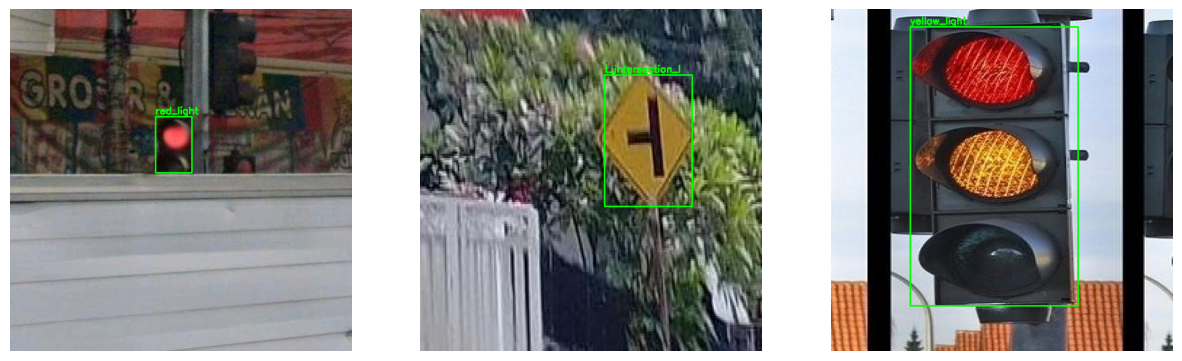

In [ ]:
import cv2, random
import matplotlib.pyplot as plt
from pathlib import Path

# Val klasöründen rastgele görseller
IMG_DIR = Path(f"{PROJ}/data/images/val")
LBL_DIR = Path(f"{PROJ}/data/labels/val")
CLASSES = open(f"{PROJ}/data.yaml").read().split("names:")[-1].strip().split("\n")
CLASSES = [c.split(":")[1].strip() for c in CLASSES if ":" in c]

def plot_img_with_labels(img_path):
    img = cv2.imread(str(img_path))
    h, w = img.shape[:2]
    label_path = LBL_DIR/f"{img_path.stem}.txt"
    if not label_path.exists():
        return img[..., ::-1]

    with open(label_path) as f:
        for line in f:
            cls, xc, yc, bw, bh = map(float, line.split())
            cls = int(cls)
            x1 = int((xc - bw/2) * w)
            y1 = int((yc - bh/2) * h)
            x2 = int((xc + bw/2) * w)
            y2 = int((yc + bh/2) * h)
            cv2.rectangle(img, (x1, y1), (x2, y2), (0,255,0), 2)
            cv2.putText(img, CLASSES[cls], (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 2)
    return img[..., ::-1]

samples = random.sample(list(IMG_DIR.glob("*.jpg")), 3)  # 3 örnek göster
plt.figure(figsize=(15,5))
for i, imgp in enumerate(samples):
    plt.subplot(1,3,i+1)
    plt.imshow(plot_img_with_labels(imgp))
    plt.axis("off")
plt.show()


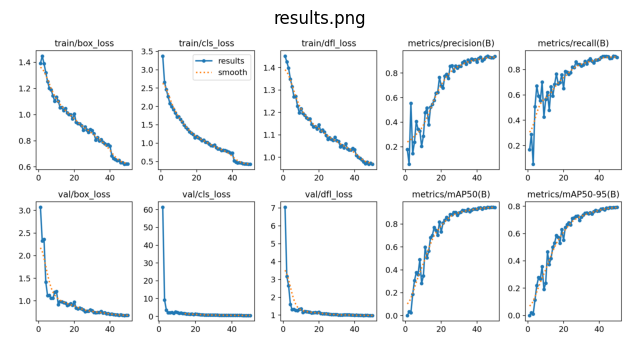

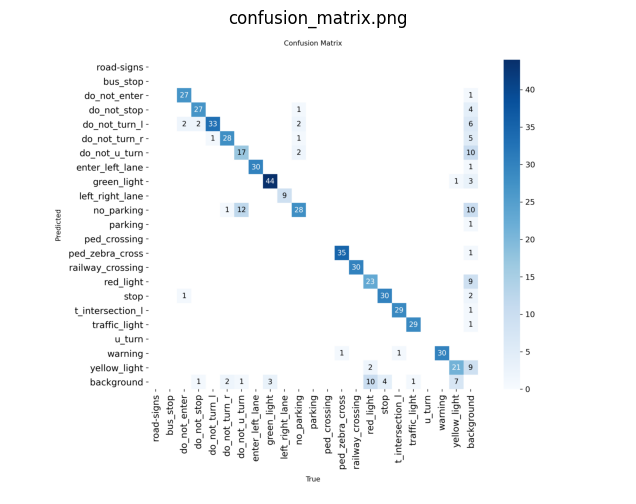

In [ ]:
import matplotlib.pyplot as plt
import cv2

for fname in ["results.png","confusion_matrix.png","PR_curve.png"]:
    img = cv2.imread(f"runs/detect/train/{fname}")
    if img is not None:
        plt.figure(figsize=(8,6))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(fname)
        plt.axis("off")
        plt.show()
